In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from thop import  clever_format

In [2]:
ESM_8M = "facebook/esm2_t6_8M_UR50D"
ESM_35M = "facebook/esm2_t12_35M_UR50D"
ESM_150M = "facebook/esm2_t30_150M_UR50D"
ESM_650M = "facebook/esm2_t33_650M_UR50D"
ESM_3B = "facebook/esm2_t36_3B_UR50D"
MODELS = [ESM_8M, ESM_35M, ESM_150M, ESM_650M, ESM_3B]

In [3]:
flops = []
memory = []
accuracy = []
seql = []
latency_df = []
gpu_util_df = []
for MODEL in MODELS: 
    mpath = MODEL.split('/')[1]
    print(MODEL)

    _flops = np.load(mpath + 'macs.npy')
    _memory = np.load(mpath + 'memory.npy')
    _accuracy = np.load(mpath + 'accuracy.npy')
    _seql = np.load(mpath + 'seql.npy')
    _latency_df = pd.read_csv("csv/" + mpath + '_latency', index_col=False )
    _gpu_util_df = pd.read_csv("csv/" + mpath + '_gpu_slen', index_col=False)

    # Preprocess flops and memory 
    t_flops = []
    t_memory = []

    for f in _flops:
        t_flops.append(2 * f / 1000000000)

    for m in _memory:
        t_memory.append(m / 1000000000)

    _flops = np.array(t_flops)
    _memory = np.array(t_memory)

    flops.append(_flops)
    memory.append(_memory)
    accuracy.append(_accuracy)
    seql.append(_seql)
    latency_df.append(_latency_df)
    gpu_util_df.append(_gpu_util_df)

facebook/esm2_t6_8M_UR50D
facebook/esm2_t12_35M_UR50D
facebook/esm2_t30_150M_UR50D
facebook/esm2_t33_650M_UR50D
facebook/esm2_t36_3B_UR50D


In [4]:
gpu_util_df[4].head()

,Unnamed: 0,timestamp,tag,duration,nvidia_gpu_0
0,0,1.712551e+09,run,9.771647,1255804
1,1,1.712551e+09,run,1.607324,235773
2,2,1.712551e+09,run,0.122652,8539
3,3,1.712551e+09,run,0.678249,110612
4,4,1.712551e+09,run,0.707501,107361


# Plotters

3.9861279369442055 0.0011456600623205304 17.292741775512695
4.472750070844169 0.00030989613151177764 16.779165267944336
5.259179176434771 0.00014661667228210717 23.1757869720459
6.663718313019422 4.0411134250462055e-05 19.789846420288086
7.815604926269156 1.9073468138230965e-06 25.420602798461914


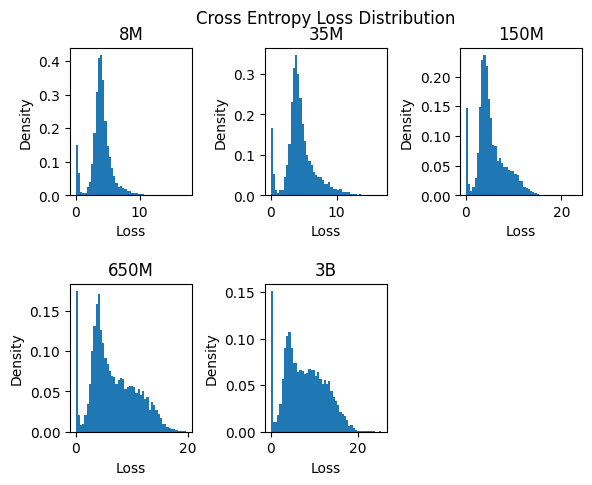

In [35]:
# Create a scatter plot\
for i in range(0, len(MODELS)):
    plt.subplot(2, 3, i+1)
    print(accuracy[i].mean(), accuracy[i].min(), accuracy[i].max())
    plt.hist(accuracy[i], 50, density=True)

    # Label the axes
    plt.xlabel('Loss')
    plt.ylabel('Density')
    plt.title(MODELS[i].split('/')[1].split('_')[2])
    
# Add a title
plt.suptitle('Cross Entropy Loss Distribution')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.6)
plt.show()

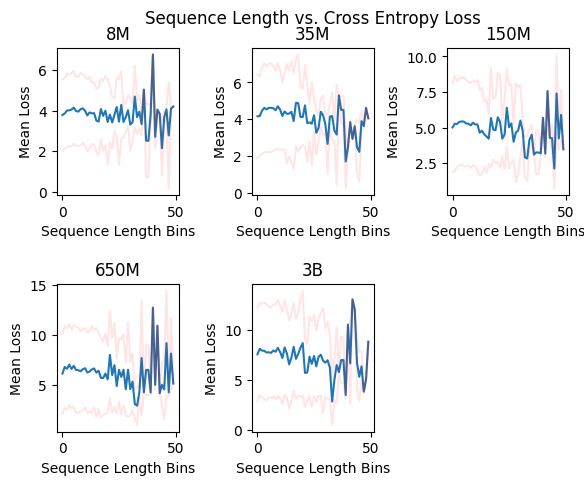

In [42]:
# Create a scatter plot\
for i in range(0, len(MODELS)):
    plt.subplot(2, 3, i+1)
    # First step, create bins
    smin = seql[i].min()
    smax = seql[i].max()
    nbins = 50
    interval = (smax - smin) / nbins
    loss_mean = []
    std_range = []

    for bin in range(0, nbins):
        lower_limit = bin * interval 
        upper_limit = (bin + 1) * interval
        indices, = np.where((seql[i] >= lower_limit) & (seql[i] < upper_limit))
        if (len(indices) == 0):
            loss_mean.append(loss_mean[len(loss_mean) - 1])
            std_range.append(std_range[len(std_range) - 1])
        else: 
            loss_mean.append(accuracy[i][indices].mean())
            std_range.append(accuracy[i][indices].std())

    plt.plot(loss_mean)
    loss_mean = np.array(loss_mean)
    std_range = np.array(std_range)
    plt.plot(loss_mean - std_range, 'r', alpha=0.5)
    plt.plot(loss_mean + std_range, 'r', alpha = 0.5)
    

    # Label the axes
    plt.xlabel('Sequence Length Bins')
    plt.ylabel('Mean Loss')
    plt.title(MODELS[i].split('/')[1].split('_')[2])
    
# Add a title
plt.suptitle('Sequence Length vs. Cross Entropy Loss')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.6)
plt.show()

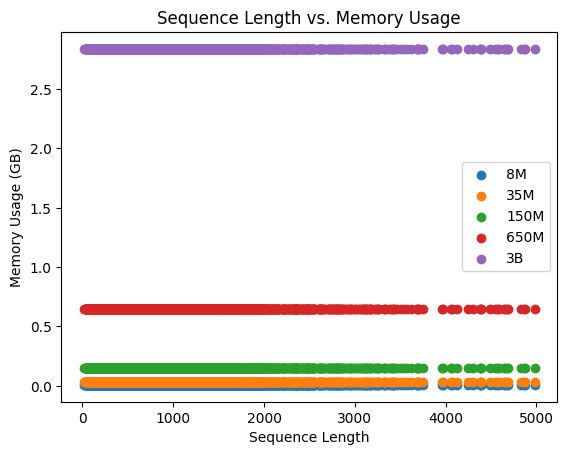

In [6]:
# Create a scatter plot
for i in range(0, len(MODELS)):
    plt.scatter(seql[i], memory[i], label = MODELS[i].split('/')[1].split('_')[2])

    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('Memory Usage (GB)')

    # Add a title
    plt.title('Sequence Length vs. Memory Usage')

# Display the plot
plt.legend()
plt.show()

In [7]:
def linear(x, a, b):
    return a * x + b

In [22]:
for i in range(0, len(MODELS)):
    _flops = flops[i]
    _latency = latency_df[i]["model_process"] / 1e9
    # _latency = np.reshape(gpu_util_df[i][['duration']].values, (-1))
    _gflopss = _flops / _latency 
    print(_gflopss.mean())

1531.6333162223586
3926.1958152736815
5568.9208358786245
14675.207776106541
19257.208668486735


In [ ]:
# Create a scatter plot
for i in range(0, len(MODELS)):
    
    plt.scatter(seql[i], flops[i], label = MODELS[i].split('/')[1].split('_')[2])

    X = seql[i]
    Y = flops[i]
    # Fit the curve
    popt, pcov = curve_fit(linear, X, Y, bounds=(0, 100), maxfev=10000)
    print(popt)
    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('GFLOPS')

    # Add a title
    plt.title('Sequence Length vs. GFLOPS')

# Display the plot
plt.legend()
plt.show()

: 

[3.78007532 0.0365981 ]


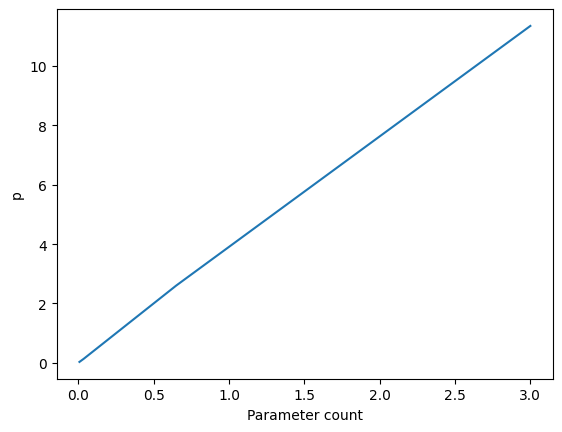

In [ ]:
Xs = [8e-3, 36e-3, 150e-3, 650e-3, 3]
Ys = [0.03, 0.1339, 0.5922, 2.6033, 11.3542]

popt, pcov = curve_fit(linear, Xs, Ys, bounds=(0, 100), maxfev=100000)
print(popt)
plt.plot(Xs, Ys)
plt.xlabel("Parameter count")
plt.ylabel("p")
plt.show()

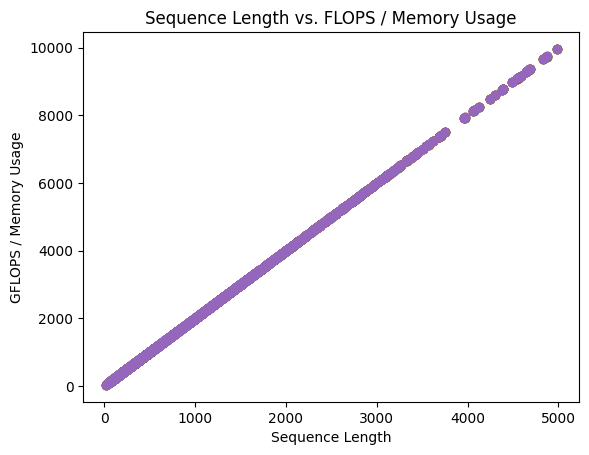

In [ ]:
# Create a scatter plot
for i in range(0, len(MODELS)):
    plt.scatter(seql[i], flops[i] / memory[i])

    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('GFLOPS / Memory Usage')

    # Add a title
    plt.title('Sequence Length vs. FLOPS / Memory Usage')

# Display the plot
plt.show()

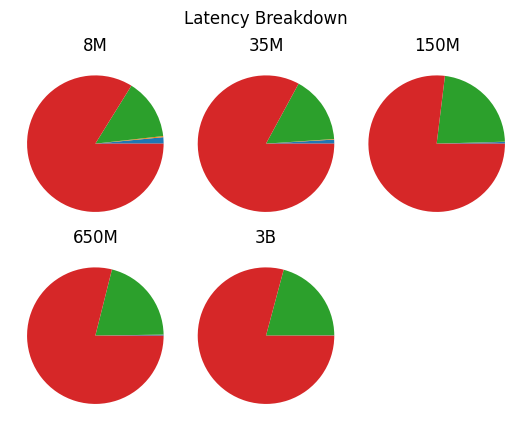

In [ ]:
for i in range(0, len(MODELS)): 
    plt.subplot(2, 3, i + 1)
    latency_sums = latency_df[i][['tokenization', 'move_inputs_to_gpu', 'model_process', 'cross_entropy_loss']].mean()
    pd.to_numeric(latency_sums,  errors='coerce')
    plt.title(MODELS[i].split('/')[1].split('_')[2])

    
    plt.pie(latency_sums.values.astype(float))

# Add a title
plt.suptitle('Latency Breakdown')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0, 
                    hspace=0)
plt.show()

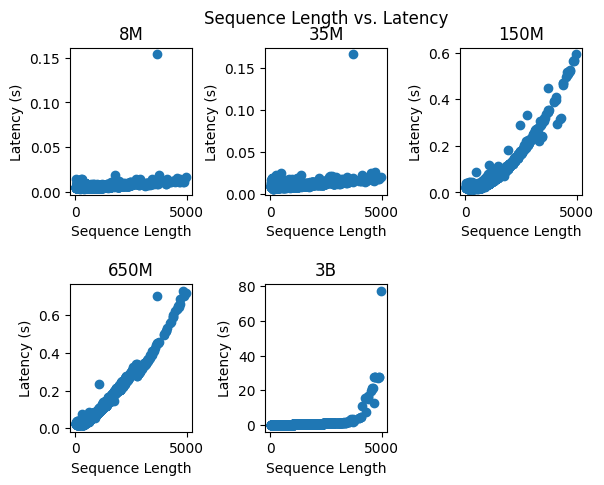

In [21]:
# Create a scatter plot\
for i in range(0, len(MODELS)):
    plt.subplot(2, 3, i + 1)
    plt.scatter(seql[i], latency_df[i][['model_process']] / 1e9)

    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('Latency (s)')
    plt.title(MODELS[i].split('/')[1].split('_')[2])
    
# Add a title
plt.suptitle('Sequence Length vs. Latency')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.6)
plt.show()

In [34]:
def general_function(x, a, p, b):
    return a * x**p  + b

[9.36818502e-10 1.92427999e+00 5.32439062e-03]
[2.24558146e-10 2.12194876e+00 9.64425185e-03]
[2.99306406e-08 1.97130869e+00 1.75586400e-02]
[4.67460915e-06 1.39957053e+00 1.29066507e-02]
[4.75069680e-33 9.19592849e+00 1.70936084e-01]


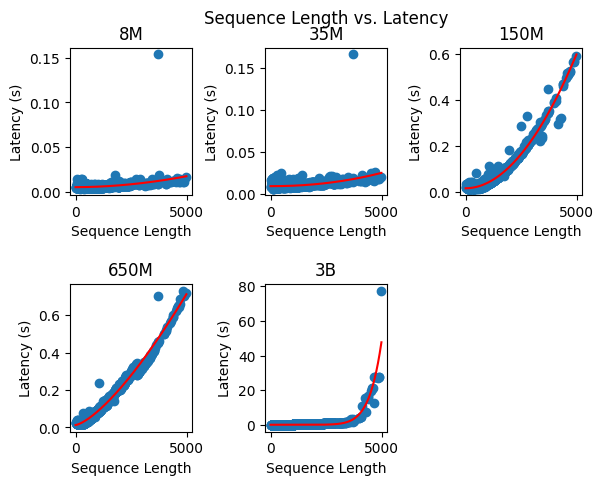

In [55]:
# Create a scatter plot\
for i in range(0, len(MODELS)):
    plt.subplot(2, 3, i + 1)
    X = seql[i]
    Y = latency_df[i][['model_process']] / 1000000000
    # Fit the curve
    popt, pcov = curve_fit(general_function, X, np.reshape(Y.values, (-1)), bounds=(0, 10), maxfev=100000)
    print(popt)

    plt.scatter(X, Y)
    _x = [i for i in range(0, max(seql[i]))]
    plt.plot(_x, general_function(_x, *popt), 'r-')

    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('Latency (s)')
    plt.title(MODELS[i].split('/')[1].split('_')[2])
    
# Add a title
plt.suptitle('Sequence Length vs. Latency')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.6)
plt.show()

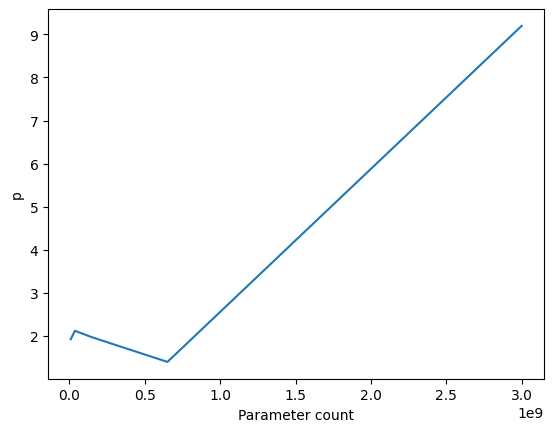

In [60]:
Xs = [8e6, 36e6, 150e6, 650e6, 3e9]
Ys = [1.9243, 2.1220, 1.9713, 1.3996, 9.1960]
plt.plot(Xs, Ys)
plt.xlabel("Parameter count")
plt.ylabel("p")
plt.show()

[8.29796530e-11 2.41800416e+00 2.33606863e-04]
[1.52302108e-09 2.17844638e+00 9.96172271e-05]
[6.51058421e-08 1.85358052e+00 9.42653306e-05]
[1.73026961e-06 1.51113145e+00 1.07919595e-03]
[9.43563012e-17 4.59016471e+00 1.11271154e-01]


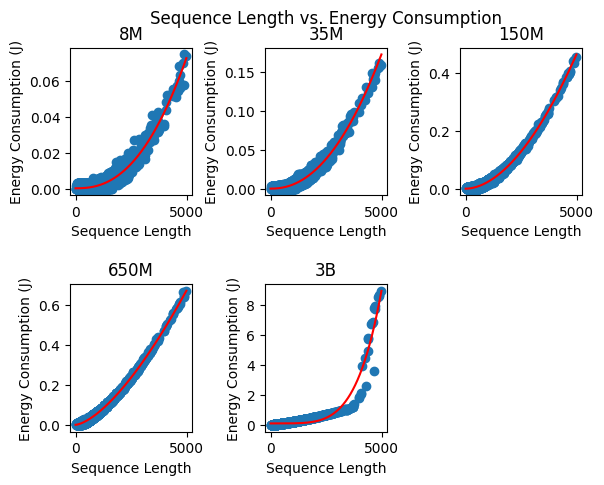

In [119]:
for i in range(0, len(MODELS)):
    plt.subplot(2, 3, i + 1)
    util = gpu_util_df[i]["nvidia_gpu_0"] / 1e6 # Energy in mJ

    X = seql[i]
    Y = (np.reshape(util.values, (-1))) 

    # Fit the curve
    popt, pcov = curve_fit(general_function, X, Y, maxfev=100000)
    print(popt)
    # Create a scatter plot
    plt.scatter(seql[i], Y)
    _x = [i for i in range(0, max(seql[i]))]
    plt.plot(_x, general_function(_x, *popt), 'r-')

    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('Energy Consumption (J)')

    # Add a title
    plt.title(MODELS[i].split('/')[1].split('_')[2])

plt.suptitle('Sequence Length vs. Energy Consumption')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.6)
plt.show()

In [138]:
def general_log_function(x, a, p, b):
    return a * np.log(x)**p  + b

[0.61656034 0.00820007 0.45758945]
[0.59293464 0.01935881 0.44084036]
[0.56306415 0.03662931 0.4210756 ]
[0.58828197 0.03309424 0.44162958]
[0.65841227 0.00898562 0.51220043]


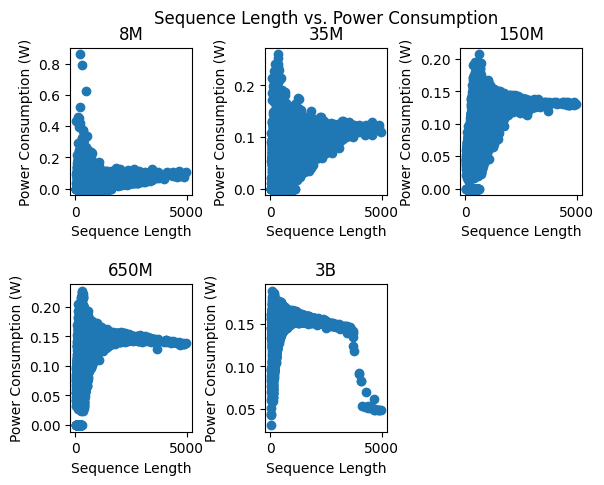

In [143]:
for i in range(0, len(MODELS)):
    plt.subplot(2, 3, i + 1)
    energy = gpu_util_df[i]["nvidia_gpu_0"] / 1e6 
    duration = np.reshape(gpu_util_df[i][['duration']].values, (-1))
    util = energy / duration

    X = seql[i]
    Y = (np.reshape(util.values, (-1)))

    # Fit the curve
    popt, pcov = curve_fit(general_function, X, Y, bounds = (0, 10), maxfev=100000)
    print(popt)
    # Create a scatter plot
    plt.scatter(seql[i], Y)

    _x = [i for i in range(1, max(seql[i]))]
    # plt.plot(_x, general_function(_x, *popt), 'r-')

    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('Power Consumption (W)')

    # Add a title
    plt.title(MODELS[i].split('/')[1].split('_')[2])

plt.suptitle('Sequence Length vs. Power Consumption')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.6)
plt.show()

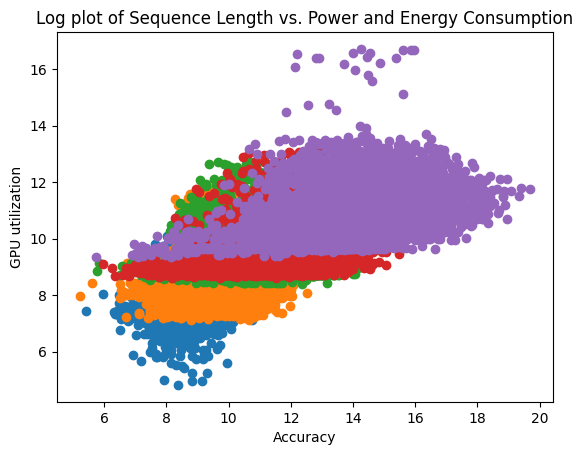

In [11]:
for i in range(0, len(MODELS)):
    duration = gpu_util_df[i]["duration"] * 100000

    # Create a scatter plot
    plt.scatter(accuracy[i], np.log(duration))

    # Label the axes
    plt.xlabel('Accuracy')
    plt.ylabel('GPU utilization')

    # Add a title
    plt.title('Log plot of Sequence Length vs. Power and Energy Consumption')

# Display the plot
plt.show()